# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

In [1]:
#!pip install pmdarima

In [2]:
import time
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from pmdarima.arima import auto_arima
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Preparación

In [3]:
df = pd.read_csv('datasets/taxi.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [4]:
df.head(5)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [5]:
df.isna().sum()

datetime      0
num_orders    0
dtype: int64

In [6]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [7]:
df = df.sort_values(by='datetime')
print(df['datetime'].is_monotonic_increasing)

True


In [8]:
df.set_index('datetime', inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [10]:
df.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [11]:
df_day = df.resample('1D').sum()

<Axes: xlabel='datetime'>

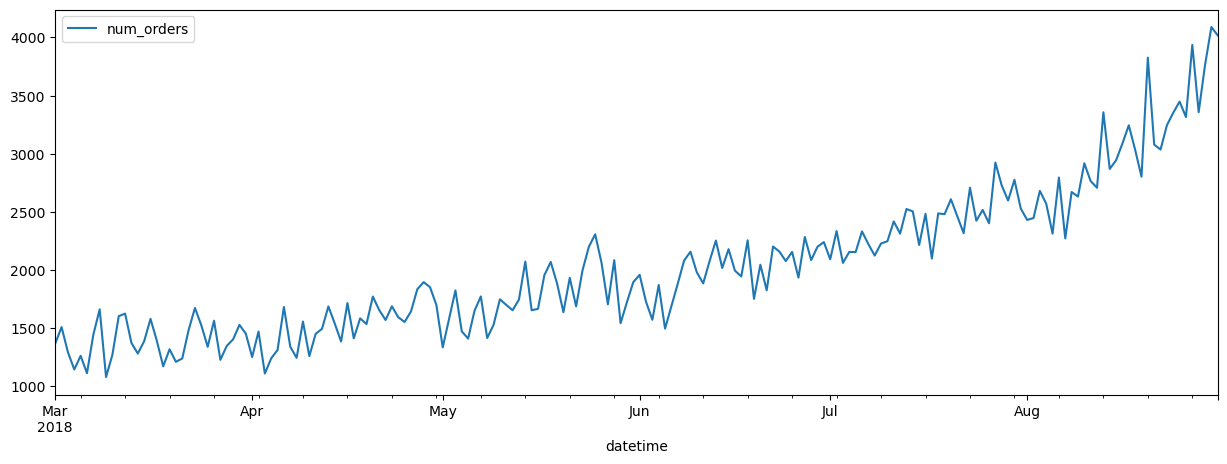

In [12]:
df_day.plot(figsize=(15,5))

## Análisis

##### Re muestreo a horas

In [13]:
df_hour = df.resample('1h').sum()

<Axes: xlabel='datetime'>

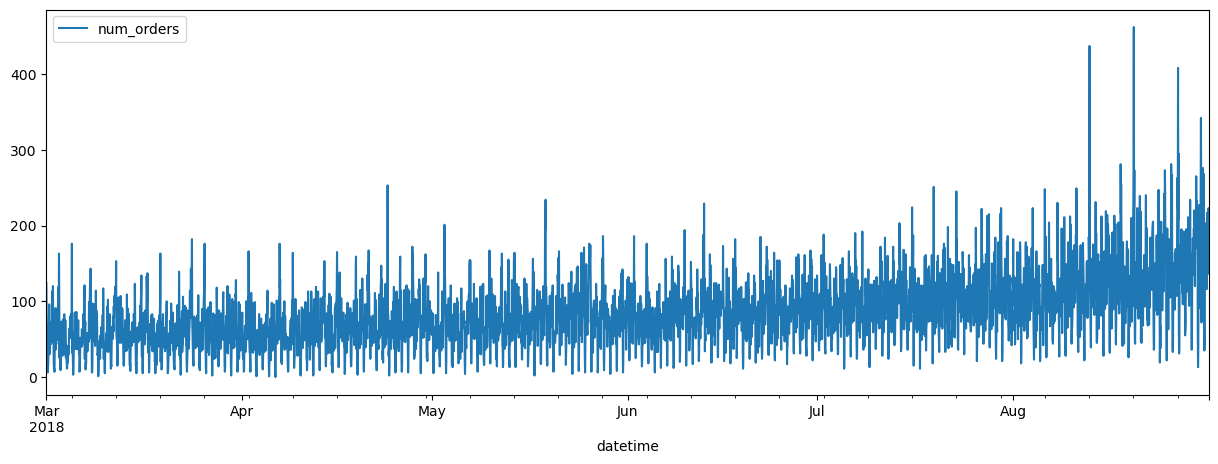

In [14]:
df_hour.plot(figsize=(15,5))

##### Media movil

In [15]:
df_hour['rolling_mean'] = df_hour.rolling(10).mean()

<Axes: xlabel='datetime'>

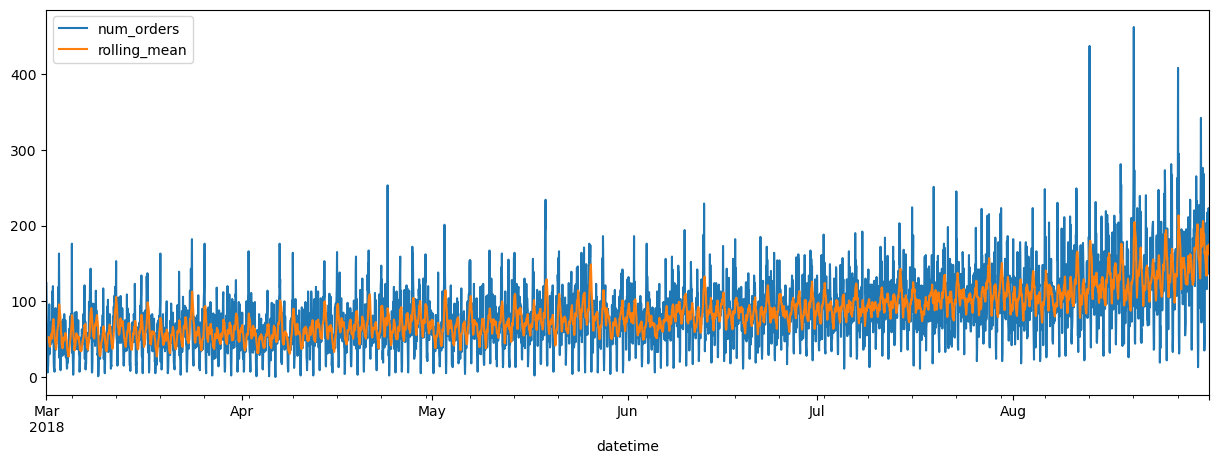

In [16]:
df_hour.plot(figsize=(15,5))

##### tendencia y estacionalidad

In [17]:
decomposed = seasonal_decompose(df_hour['num_orders'])

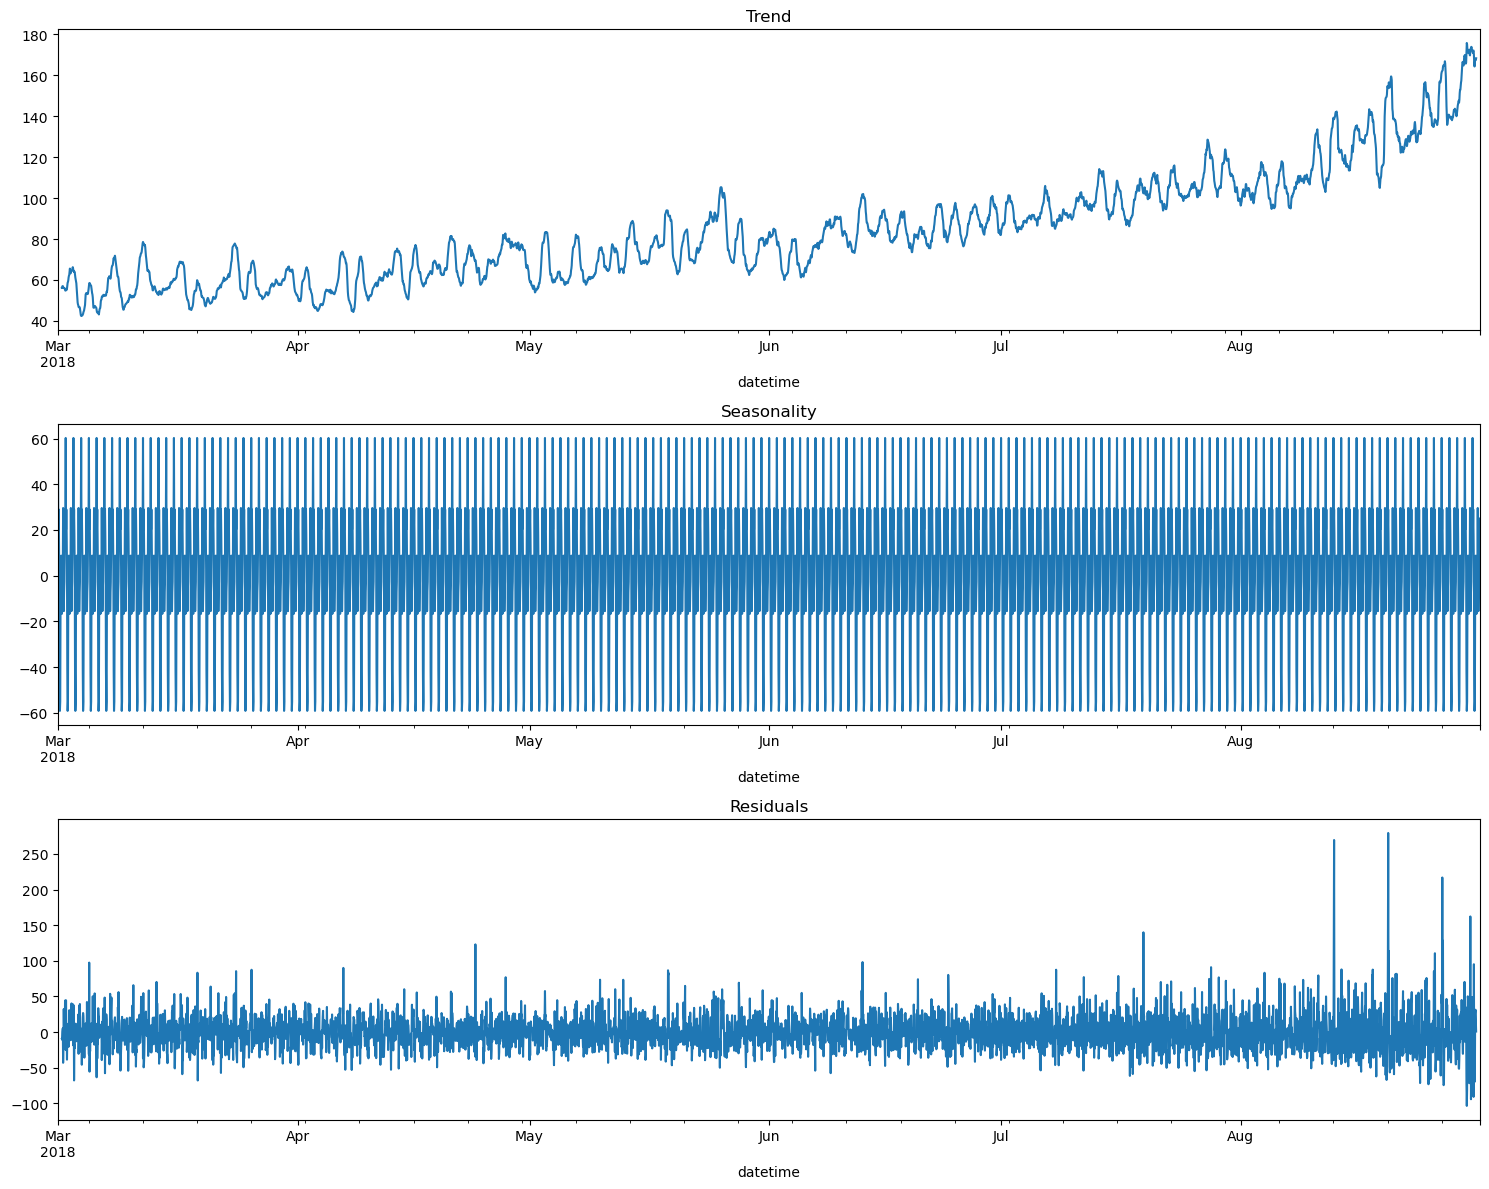

In [18]:
plt.figure(figsize=(15,12))
plt.subplot(311)
# Para mostrar el gráfico de manera correcta, especifica su
# eje ax igual a plt.gca() (gca = obtener el eje actual)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

## Formación

##### Simple linear regression 
_________________________

In [19]:
df_hour = df_hour.drop(['rolling_mean'], axis=1)

In [20]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = (
        data['num_orders'].shift().rolling(rolling_mean_size).mean()
    )

In [21]:
df_hour_lr = df_hour.copy()
make_features(df_hour_lr, 6, 10)
train, test = train_test_split(df_hour_lr, shuffle=False, test_size=0.2)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [22]:
init = time.time()
model = LinearRegression()
model.fit(features_train, target_train)
end = time.time()
training_time = end - init

pred_test = model.predict(features_test)

print()
print("Speed execution")
print("Training: {:.5f}".format(training_time))


Speed execution
Training: 0.01287


In [23]:
print('RMSE para el conjunto de prueba:', mean_absolute_error(target_test, pred_test))

RMSE para el conjunto de prueba: 35.7960153187139


##### Time Serie's Forecasting: ARIMA
__________

In [24]:
df_hour_arima = df_hour.copy()
train_arima, test_arima = train_test_split(df_hour_arima, shuffle=False, test_size=0.2)
train_arima = train_arima.dropna()

In [25]:
init = time.time()
# instanciar modelo
model = auto_arima(train_arima['num_orders'], trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_arima)

end = time.time()
training_time = end - init

forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test_arima.index,columns=['Prediction'])

print()
print("Speed execution")
print("Training: {:.5f}".format(training_time))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.01 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=35031.830, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=34660.207, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=34502.342, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=35029.831, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.45 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=34500.345, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=34658.208, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.60 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 7.596 seconds

Speed execution
Training: 7.77877


In [26]:
rms = sqrt(mean_absolute_error(test_arima,forecast))
print("RMSE para el conjunto de prueba: ", rms)

RMSE para el conjunto de prueba:  6.829751457674144


##### Time Serie's Forecasting: SARIMAX
__________

In [27]:
df_hour_sarimax = df_hour.copy()

init = time.time()
# instanciar modelo
sarima_model = SARIMAX(df_hour_sarimax, order=(2,0,1), seasonal_order=(2, 1, 0, 24))
results = sarima_model.fit()

end = time.time()
training_time = end - init

print()
print("Speed execution")
print("Training: {:.5f}".format(training_time))


Speed execution
Training: 18.88350


In [28]:
rms = sqrt(results.mse)
print("RMSE para el conjunto de prueba: ", rms)

RMSE para el conjunto de prueba:  26.879211729977175


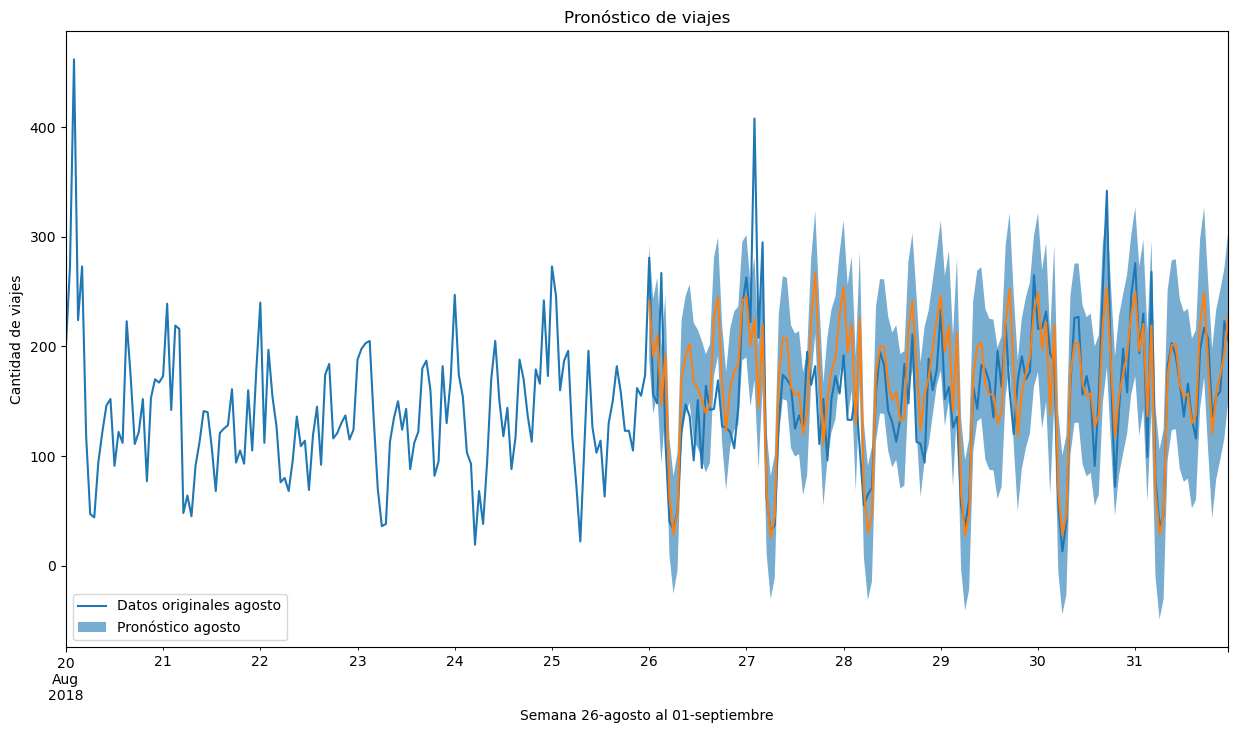

In [30]:
# tomar de datos originales dias 29-oct, 30-oct, y 31-oct
df_agosto = df_hour_sarimax.loc['2018-08-20':'2018-09-01']
df_agosto.plot(figsize=(15,8))

# agregar bandas de confianza
pred_agosto_conf = results.get_forecast(steps=72*2).conf_int()
pred_agosto_conf.index = pd.date_range(start='08/26/2018', end='09/01/2018', freq='h')[:-1]
x = pd.date_range(start='08/26/2018', end='09/01/2018', freq='h')[:-1]
y1 = pred_agosto_conf['lower num_orders']
y2 = pred_agosto_conf['upper num_orders']
plt.fill_between(x, y1, y2, alpha=0.6)

# predecir para 1-nov y 2-nov
pred_aug = results.get_forecast(steps=72*2).predicted_mean
pred_aug.index = pd.date_range(start='08/26/2018', end='09/01/2018', freq='h')[:-1]
pred_aug.plot()

# formato de la grafica final
plt.title('Pronóstico de viajes')
plt.ylabel('Cantidad de viajes')
plt.xlabel('Semana 26-agosto al 01-septiembre')
plt.legend(('Datos originales agosto', 'Pronóstico agosto'),
           loc='lower left')
plt.show()

## Prueba

La siguiente tabla muestra los parametros obtenidos para los modelos de Forecast, observamos que pudimos obtener un mejor rendimiento para ambos modelos comparados con la regresión lineal simple

| Modelo              | RMSE       | training-Time | prediction-Time |
|---------------------|------------|---------------|-----------------|
| Linear Regression   | 35.79601   | 0.00273       | 0.00405         |
| ARIMA               | 06.82975   | 7.90660       | 0.25954         |
| SARIMAX             | 26.87921   | 20.00148      | 0.26189         |

Vemos que el mejor resultado obtenido es con el modelo **ARIMA** usando el RMSE como funcion de perdida. Probablemente es el mejor modelo. Además este modelo tambien es suficientemente rápido en el proceso de **entrenamiento** con 7.90 seg, aunque considero aun podemos encontrar cualquiera de los 3 modelos como validos.

Además los 3 modelos cumplen con estar debajo del umbral esperado de RMSE < 48

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [ ]  	
Los datos han sido descargados y preparados.
- [ ]  Se ha realizado el paso 2: los datos han sido analizados
- [ ]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [ ]  Se han evaluado los modelos. Se expuso una conclusión
- [ ] La *RECM* para el conjunto de prueba no es más de 48 (root mean square error)